In [1]:
#4qubitのSStronglyEntanglingLayers(https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import AdagradOptimizer
import matplotlib.pyplot as plt

In [2]:
#HWE回路のパラメータの読み込み
weights_005= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_5_6_weights.npy')
weights_035= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_35_6_weights.npy')

#データセットの読み込み
train_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/train_HWE_4q_6_005_035_no3.csv'
train_data = np.loadtxt(train_path, delimiter=',',)
X_train = train_data[:, :-1] 
y_train = train_data[:, -1]

test_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/test_HWE_4q_6_005_035_no3.csv'
test_data = np.loadtxt(test_path, delimiter=',',)
X_test = test_data[:, :-1] 
y_test = test_data[:, -1] 


In [7]:
default_qubit = 4
copy = 2
n_wires = default_qubit * copy
dev = qml.device('default.qubit', wires=n_wires)
@qml.qnode(dev)
def circuit(params,x):
    #HWE回路のパラメータの選択
    if x[-1] == -1:
        gen_params = weights_005
    else:
        gen_params = weights_035
    x = x[:-1]
    x = x.reshape( ( int(x.shape[0]/2) , 2) )

    #積状態の入力
    for c in range(copy):
        for i in range(default_qubit):
            qml.RZ(x[i][1],wires=i + default_qubit * c )
            qml.RY(x[i][0],wires=i + default_qubit * c)

        #HWE回路
        for layer in range(gen_params.shape[0]):
            for i in range(default_qubit):
                qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i + default_qubit * c)
            for i in range(int(default_qubit/2)):
                qml.CZ(wires=[2*i+default_qubit * c,2*i+1+default_qubit * c])
            for i in range(default_qubit):
                qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i + default_qubit * c)
            for i in range(int((default_qubit-1)/2)):
                qml.CZ(wires=[2*i+1 + default_qubit * c,2*i+2 + default_qubit * c])

    qml.StronglyEntanglingLayers(params, wires=range(n_wires))


    return qml.expval(qml.PauliZ(0))


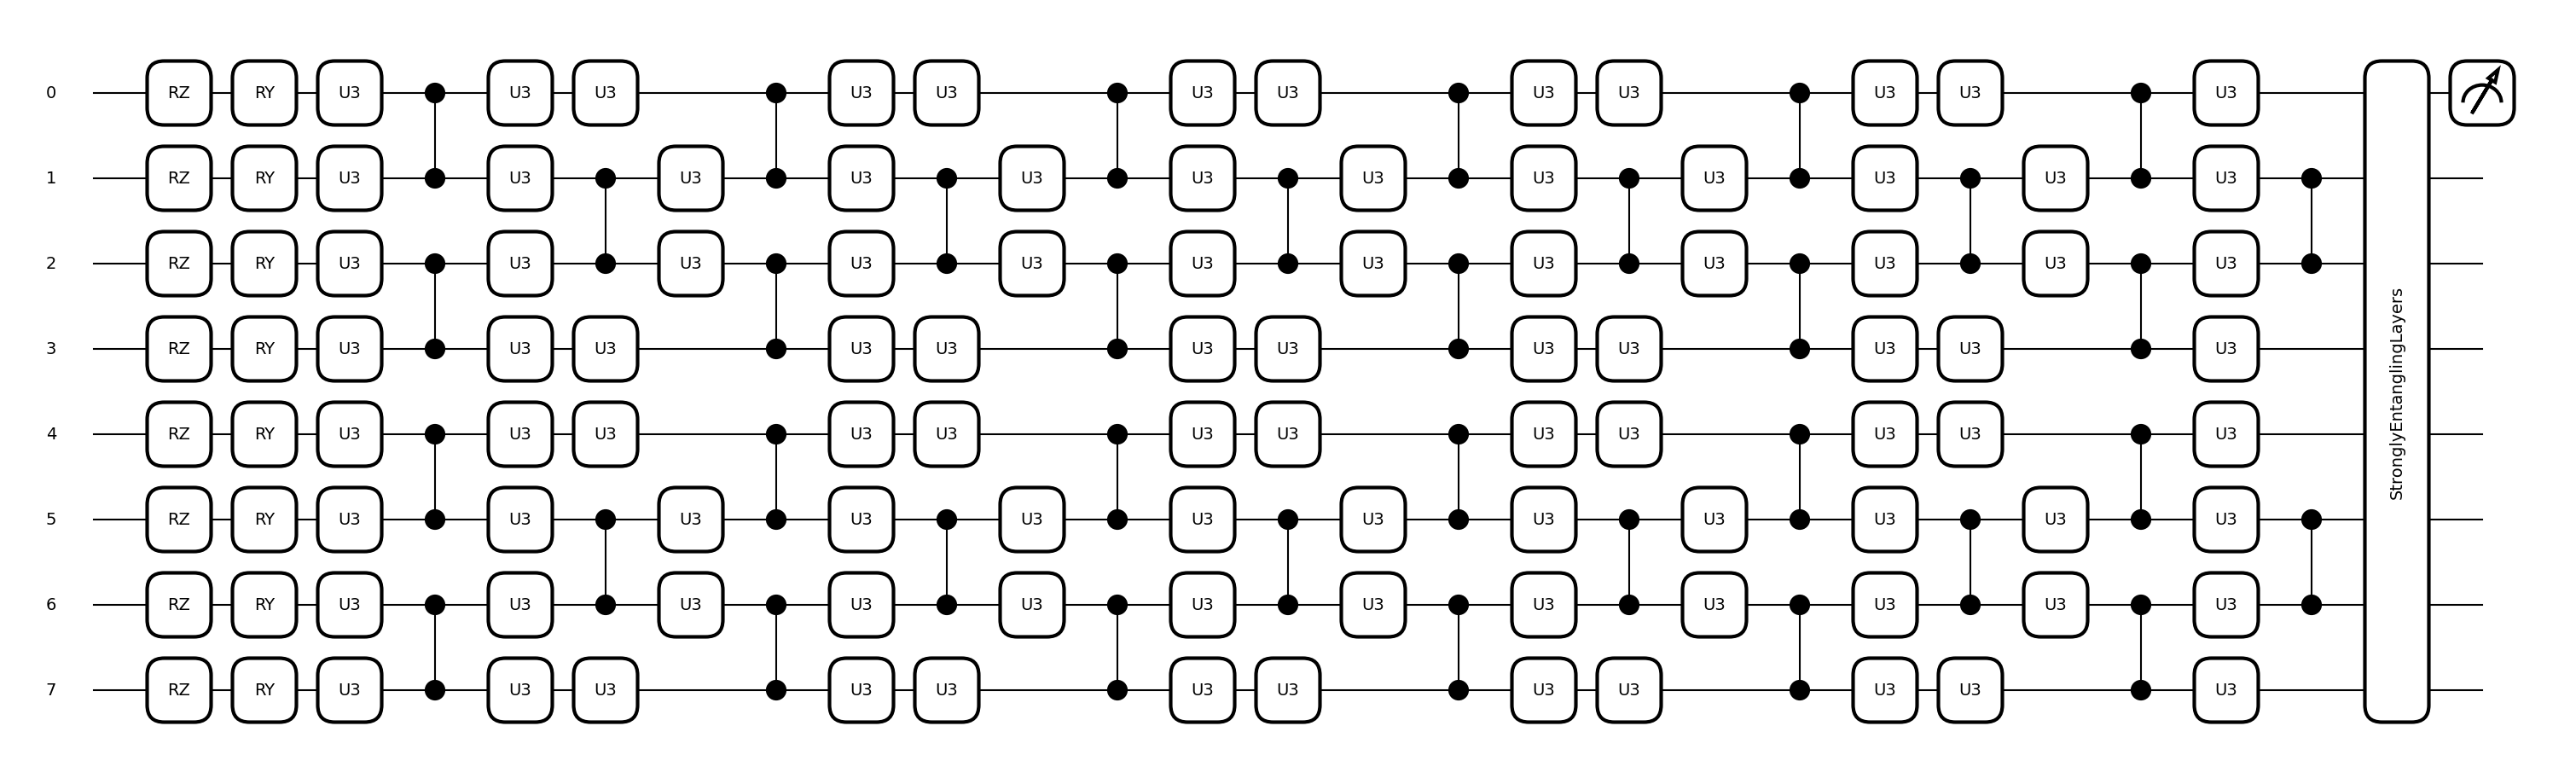

Cost after step 1: 1.0328404083899725
Cost after step 2: 1.026346364104169
Cost after step 3: 1.019914304918299
Cost after step 4: 1.0135761072402858
Cost after step 5: 1.0073725371035414
Cost after step 6: 1.0013325633001657
Cost after step 7: 0.9954774641358622
Cost after step 8: 0.9898309589281697
Cost after step 9: 0.984416484236862
Cost after step 10: 0.9792535907711468
Cost after step 11: 0.9743576073476958
Cost after step 12: 0.9697388199797259
Cost after step 13: 0.9653986997258546
Cost after step 14: 0.9613262017660108
Cost after step 15: 0.9574980237423252
Cost after step 16: 0.953880461149722
Cost after step 17: 0.9504321033081518
Cost after step 18: 0.9471109884591473
Cost after step 19: 0.9438840853922575
Cost after step 20: 0.9407330192173649
Cost after step 21: 0.9376541344616123
Cost after step 22: 0.9346548167390645
Cost after step 23: 0.9317484892813147
Cost after step 24: 0.928950341256593
Cost after step 25: 0.9262748265708977
Cost after step 26: 0.9237340621562271


In [9]:
np.random.seed(42)  # ここで好きな整数を指定
shape = qml.StronglyEntanglingLayers.shape(n_layers = 5, n_wires = 8)
params = np.random.random(size=shape)
params.requires_grad = True  # 勾配計算を有効にする

def loss(p):
    predictions = np.array([circuit(p, x) for x in X_train])
    return np.mean((predictions - y_train) ** 2)

opt = AdamOptimizer(0.01)
steps = 200

fig, ax =qml.draw_mpl(circuit)(params, X_train[0])
plt.show()
plt.close()
#print(qml.draw(circuit)(params,X_train[0]))

loss_values = []
loss_values.append(loss(params))
for i in range(steps):
    params = opt.step(loss, params)
    current_loss = loss(params)
    loss_values.append(current_loss)
    print(f"Cost after step {i + 1}: {current_loss}")
        
predictions = np.array([np.sign(circuit(params, x)) for x in X_test])
accuracy = np.mean(predictions == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

print(loss_values)

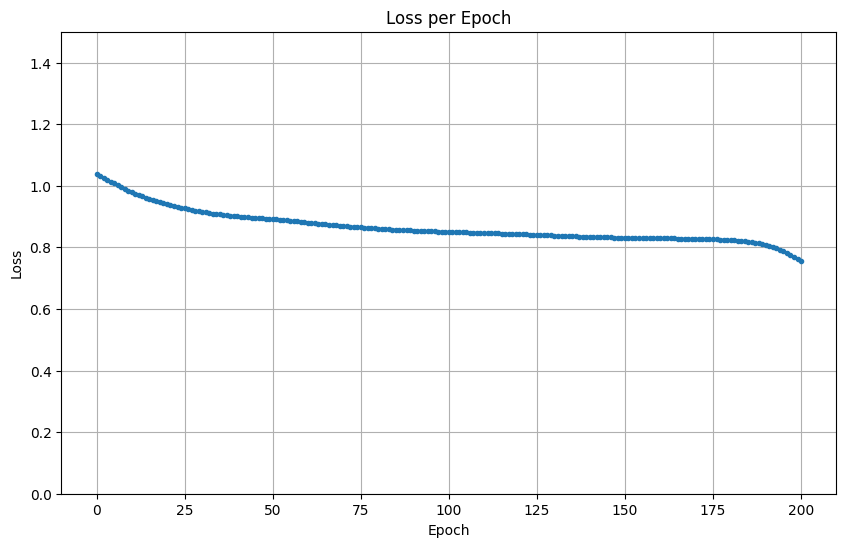

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, steps + 1), loss_values, marker='.')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.grid()
plt.show()

In [13]:
loss_values2 = loss_values

for i in range(200):
    params = opt.step(loss, params)
    current_loss = loss(params)
    loss_values2.append(current_loss)
    print(f"Cost after step {i + 1}: {current_loss}")
        
predictions = np.array([np.sign(circuit(params, x)) for x in X_test])
accuracy = np.mean(predictions == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

[tensor(1.03937976, requires_grad=True), tensor(1.03284041, requires_grad=True), tensor(1.02634636, requires_grad=True), tensor(1.0199143, requires_grad=True), tensor(1.01357611, requires_grad=True), tensor(1.00737254, requires_grad=True), tensor(1.00133256, requires_grad=True), tensor(0.99547746, requires_grad=True), tensor(0.98983096, requires_grad=True), tensor(0.98441648, requires_grad=True), tensor(0.97925359, requires_grad=True), tensor(0.97435761, requires_grad=True), tensor(0.96973882, requires_grad=True), tensor(0.9653987, requires_grad=True), tensor(0.9613262, requires_grad=True), tensor(0.95749802, requires_grad=True), tensor(0.95388046, requires_grad=True), tensor(0.9504321, requires_grad=True), tensor(0.94711099, requires_grad=True), tensor(0.94388409, requires_grad=True), tensor(0.94073302, requires_grad=True), tensor(0.93765413, requires_grad=True), tensor(0.93465482, requires_grad=True), tensor(0.93174849, requires_grad=True), tensor(0.92895034, requires_grad=True), ten